 # **redo to test difference b/t trials**

In [1]:
library(dplyr)
library(stringr)
library(ggplot2)
library(patchwork)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Saving 6.67 x 6.67 in image



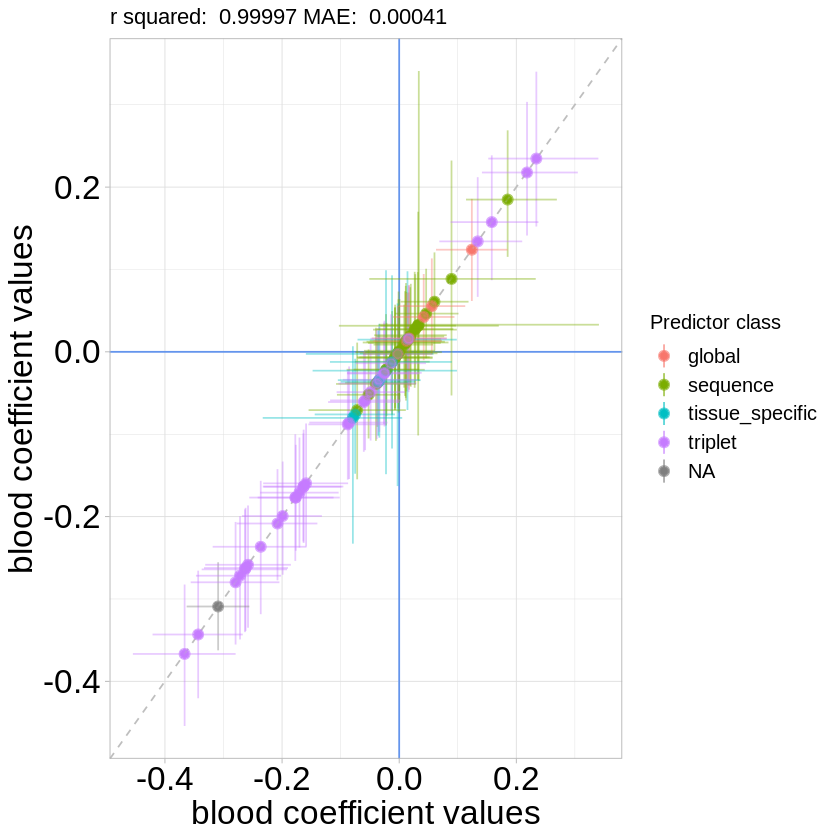

In [24]:
tissue = "blood"


n_bootstrap=10000
model_name="model6"
equiv_toLowest=TRUE
exclude_triplet = FALSE
exclude_CpG= FALSE

tmp_file_path = "../../../"


model_desc_modify = ""
if (equiv_toLowest==TRUE){
    model_desc_modify = paste(model_desc_modify,"_bloodEquiv",sep="")}
if (n_bootstrap==1000){
    model_desc_modify = paste(model_desc_modify,"_boot1k",sep="")
} else if (n_bootstrap==10000){
    model_desc_modify = paste(model_desc_modify,"_boot10k",sep="")
}
if (exclude_CpG==TRUE){
    model_desc_modify = paste(model_desc_modify,"_noCpG",sep="")}
if (exclude_triplet==TRUE){
    model_desc_modify = paste(model_desc_modify,"_noTriplets",sep="")}


#REPEAT ABOVE BUT FOR EQUIVALENTLY SIZED 
#reading in data
tissue_coefs <- read.csv(paste(tmp_file_path,"data/",tissue,"/dataframes/",model_name,"/",tissue,"_coefDF_bootstrap_bloodEquiv_boot10k.csv",sep=""))
tissue_predOn_coefs <- read.csv(paste(tmp_file_path,"data/",tissue,"/dataframes/",model_name,"/",tissue,"_coefDF_bootstrap_bloodEquiv_boot10k1.csv",sep=""))

tissue_coefs_reduced <- data.frame(tissue_coefs$name, tissue_coefs$mean_est,tissue_coefs$quant025,tissue_coefs$quant975)
tissue_predOn_coefs_reduced <-data.frame(tissue_predOn_coefs$name,tissue_predOn_coefs$mean_est,tissue_predOn_coefs$quant025,tissue_predOn_coefs$quant975)
colnames(tissue_coefs_reduced) <- c("name",'tissue_est','tissue_quant025','tissue_quant975')
colnames(tissue_predOn_coefs_reduced) <- c("name",'tissue_predOn_est','tissue_predOn_quant025','tissue_predOn_quant975')
all_coefs <- merge(tissue_coefs_reduced,tissue_predOn_coefs_reduced,on="name",all=T)#for some reason the dim b/t germ and blood are different so need a merge... 
colnames(all_coefs) <- c("name","tissue_est","tissue_quant025","tissue_quant975","tissue_predON_est","tissue_predON_quant025","tissue_predON_quant975")


#create col that categorizes 
all_coefs<-all_coefs %>%
    mutate(type = case_when(        
        str_detect(name, 'percent') ~ 'sequence',
        str_detect(name, 'Chromosome') ~ 'sequence',
        str_detect(name, 'Repeats') ~ 'sequence',
        str_detect(name, 'site') ~ 'sequence',
        str_detect(name, 'annot') ~ 'sequence',
        str_detect(name, 'content') ~ 'sequence',
        str_detect(name, 'CpG') ~ 'sequence',
        
        str_detect(name, 'triplet') ~ 'triplet',
        
        str_detect(name, 'DNAse') ~ 'tissue_specific',
        str_detect(name, 'Transcription') ~ 'tissue_specific',
        str_detect(name, 'H3k') ~ 'tissue_specific',
        str_detect(name, 'methyl') ~ 'tissue_specific',
        
        str_detect(name, 'recomb') ~ 'global',
        str_detect(name, 'lamin') ~ 'global',
        str_detect(name, 'Replication') ~ 'global',
        str_detect(name, 'dist_rep') ~ 'global',
        
#         str_detect(name, 'Intercept') ~ 'intercept',
    ))

# all_sign_coefs <- filter(all_coefs[order(-all_coefs$tissue_est),],(tissue_quant025*tissue_quant975>0)|(tissue_predON_quant025*tissue_predON_quant975>0))

colors_ggplot <- c(sequence = "#7CAE00", triplet = "#C77CFF", global ='#F8766D', tissue_specific = '#00BFC4', intercept = "darkgrey")


#plotting
ggplot(all_coefs, aes(y = tissue_est, x = tissue_predON_est,label=name)) +
    geom_point(aes(color=type) )+
    theme_light()+
#     scale_y_continuous(breaks=seq(-0.75,1.75,0.75)) +
#     scale_x_continuous(breaks=seq(-0.75,1.75,0.75)) +
    geom_abline(intercept=0, slope=1, col="grey",linetype="dashed")+ #http://www.sthda.com/english/wiki/ggplot2-line-types-how-to-change-line-types-of-a-graph-in-r-software
    geom_abline(intercept=0, slope=0, col="cornflowerblue")+
    geom_vline(xintercept=0,col="cornflowerblue") + #http://www.sthda.com/english/wiki/ggplot2-add-straight-lines-to-a-plot-horizontal-vertical-and-regression-lines
    labs(
        x = paste(tissue," coefficient values",sep=""),
        y = paste(tissue," coefficient values",sep=""),
        color = "Predictor class"#https://stackoverflow.com/questions/14622421/how-to-change-legend-title-in-ggplot
        ) +
    theme(
    axis.text = element_text(size = 20, family = 'Helvetica', color = 'black'),
    axis.title = element_text(size = 20, family = 'Helvetica'),
    legend.title = element_text(size=12, family = 'Helvetica'),
    legend.text = element_text(size = 12, family = 'Helvetica')
    )  +
    geom_pointrange(aes(ymin=tissue_quant025, ymax=tissue_quant975, color=type),alpha=0.4)+
    geom_pointrange(aes(xmin=tissue_predON_quant025, xmax=tissue_predON_quant975, color=type),alpha=0.4)+
    ggtitle(paste("r squared: ",round(summary(fit)$r.squared,5), "MAE: ",round(mean(abs(all_coefs$tissue_est - all_coefs$tissue_predON_est),na.rm=TRUE),5)))
#     geom_text(hjust=0, vjust=0,aes(color=type),size=2)#https://stackoverflow.com/questions/15624656/label-points-in-geom-point
ggsave(paste(tmp_file_path,"analysis/global/plots/",model_name,"/coefScatter_",tissue,"_on_",tissue,model_desc_modify,".pdf",sep=""))

MAE = mean(abs(all_coefs$tissue_est - all_coefs$tissue_predON_est),na.rm=TRUE)
# string_to_print = paste("mean absolute error is for sign coefs only ",round(MAE,4),sep=" ")
# cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)
fit<-lm(tissue_est~tissue_predON_est,data=all_coefs)
# string_to_print = paste("r-squared is for sign coefs only",summary(fit)$r.squared,sep=" ")
# cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)

 # **checking b/t full model and other**